In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib as mpl
import seaborn as sns

In [2]:
%reload_ext autoreload
%autoreload 2
%timeit

# Add repo path to system path if it is not already there
# This allows us to import the package
import sys
GIT_REPO_PATH = "/home/jupyter/github_repos/"
if GIT_REPO_PATH not in sys.path: sys.path.append(GIT_REPO_PATH)

# Set global configuration
!git config --global user.email daniel.charytonowicz@icahn.mssm.edu
!git config --global user.name dchary

# make the repo if it doesnt exist
!mkdir /home/jupyter/github_repos/

# Import base packages required
import sys, os, scipy, random, gc, warnings, re, anndata
import numpy as np
import pandas as pd
import scanpy as sc
from importlib import reload
from tqdm.auto import tqdm
import tensorflow as tf
import textwrap
import matplotlib as mpl
import matplotlib.pyplot as plt

import ucdeconvolve_old.ucdeconvolve as ucd

mkdir: cannot create directory ‘/home/jupyter/github_repos/’: File exists


2022-12-12 18:28:00.044531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 18:28:00.054153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 18:28:00.054776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 18:28:00.055820: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [223]:
studies_metadata = pd.read_csv("studies_metadata.csv")
studies_metadata['Date'] = studies_metadata["Date"].astype("datetime64")
studies_metadata = studies_metadata.set_index("Date")

data = studies_metadata.groupby(pd.Grouper(freq='Q')).count()['Title'].head(30)
data.index = data.index.map(lambda t: t.strftime('%b %y'))

In [180]:
data_ncells = studies_metadata.groupby(pd.Grouper(freq='Q'))['Cells'].mean().dropna()
data_ncells.index = data_ncells.index.map(lambda t: t.strftime('%b %y'))

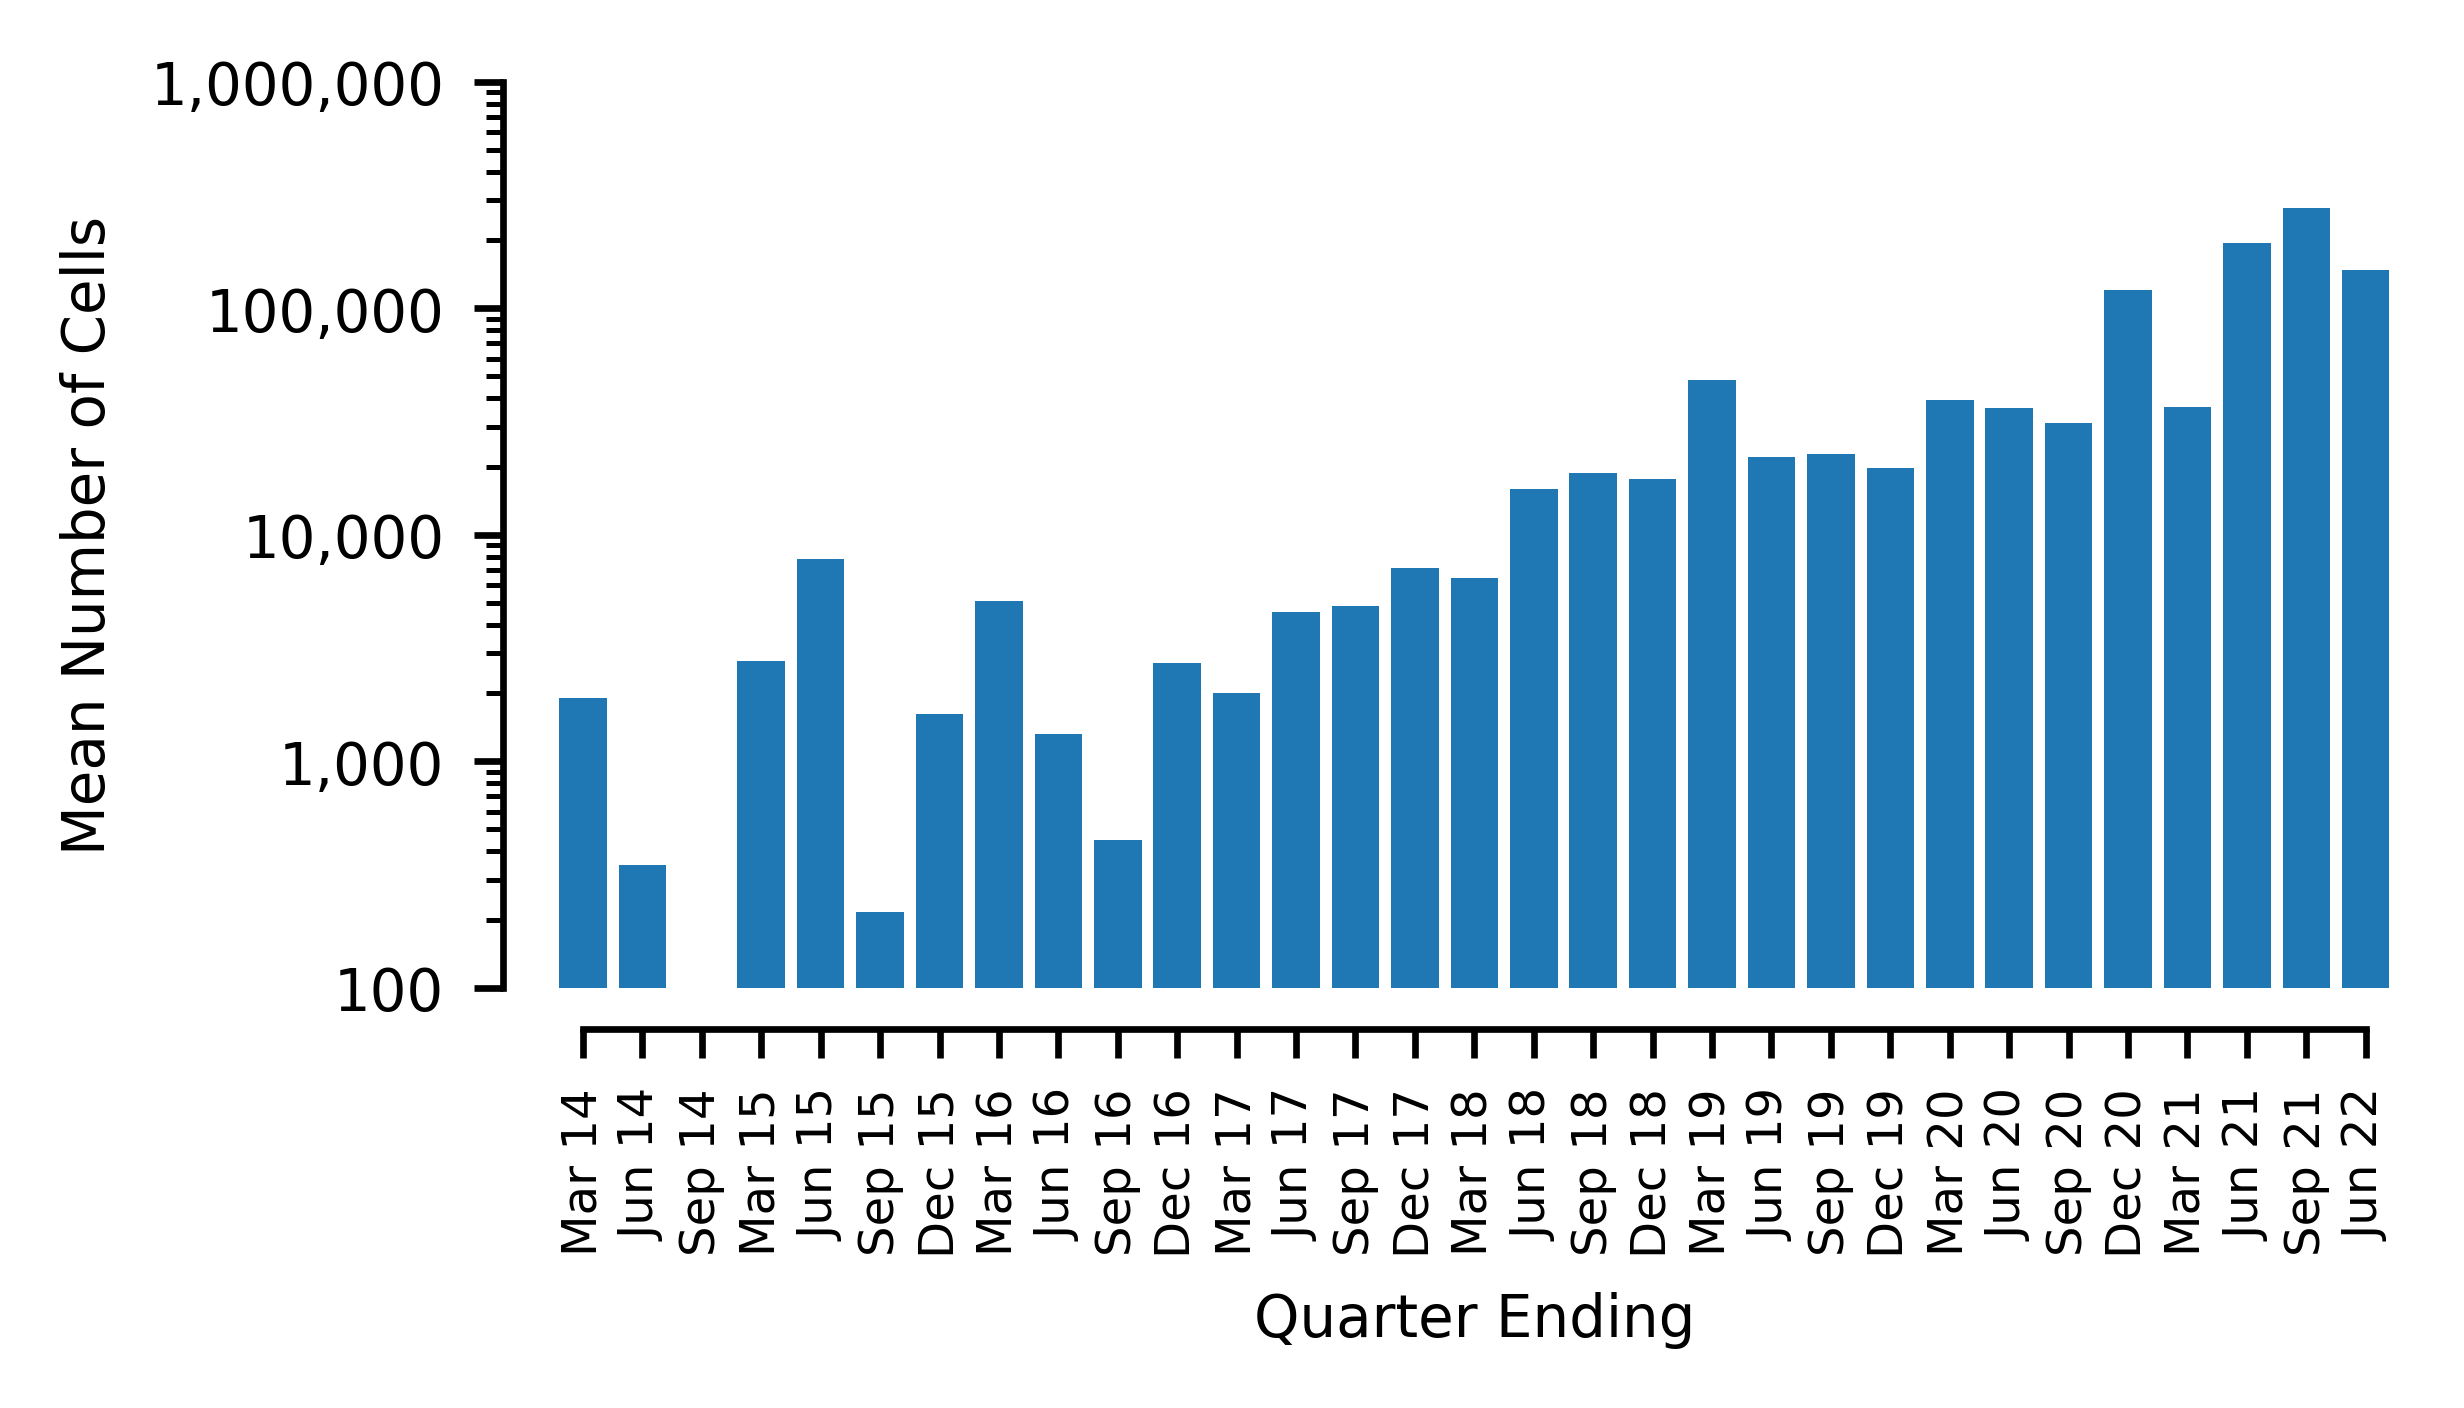

In [221]:
fig, ax = plt.subplots(1,1, figsize = (4,2), dpi = 600)

data_ncells.plot.bar(ax = ax, width = 0.8)
ax.set_yscale("log")
ax.xaxis.set_tick_params(labelsize = "xx-small", rotation = 90)
ax.yaxis.set_tick_params(labelsize = "x-small")
ax.set_ylabel("Mean Number of Cells", fontsize = "x-small")
ax.set_xlabel("Quarter Ending", fontsize = "x-small")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_locator(mpl.ticker.LogLocator(10))
ax.set_ylim(10e1,10e5)
sns.despine(ax = ax, offset = 5, trim = True)


Text(0.5, 0, 'Quarter Ending')

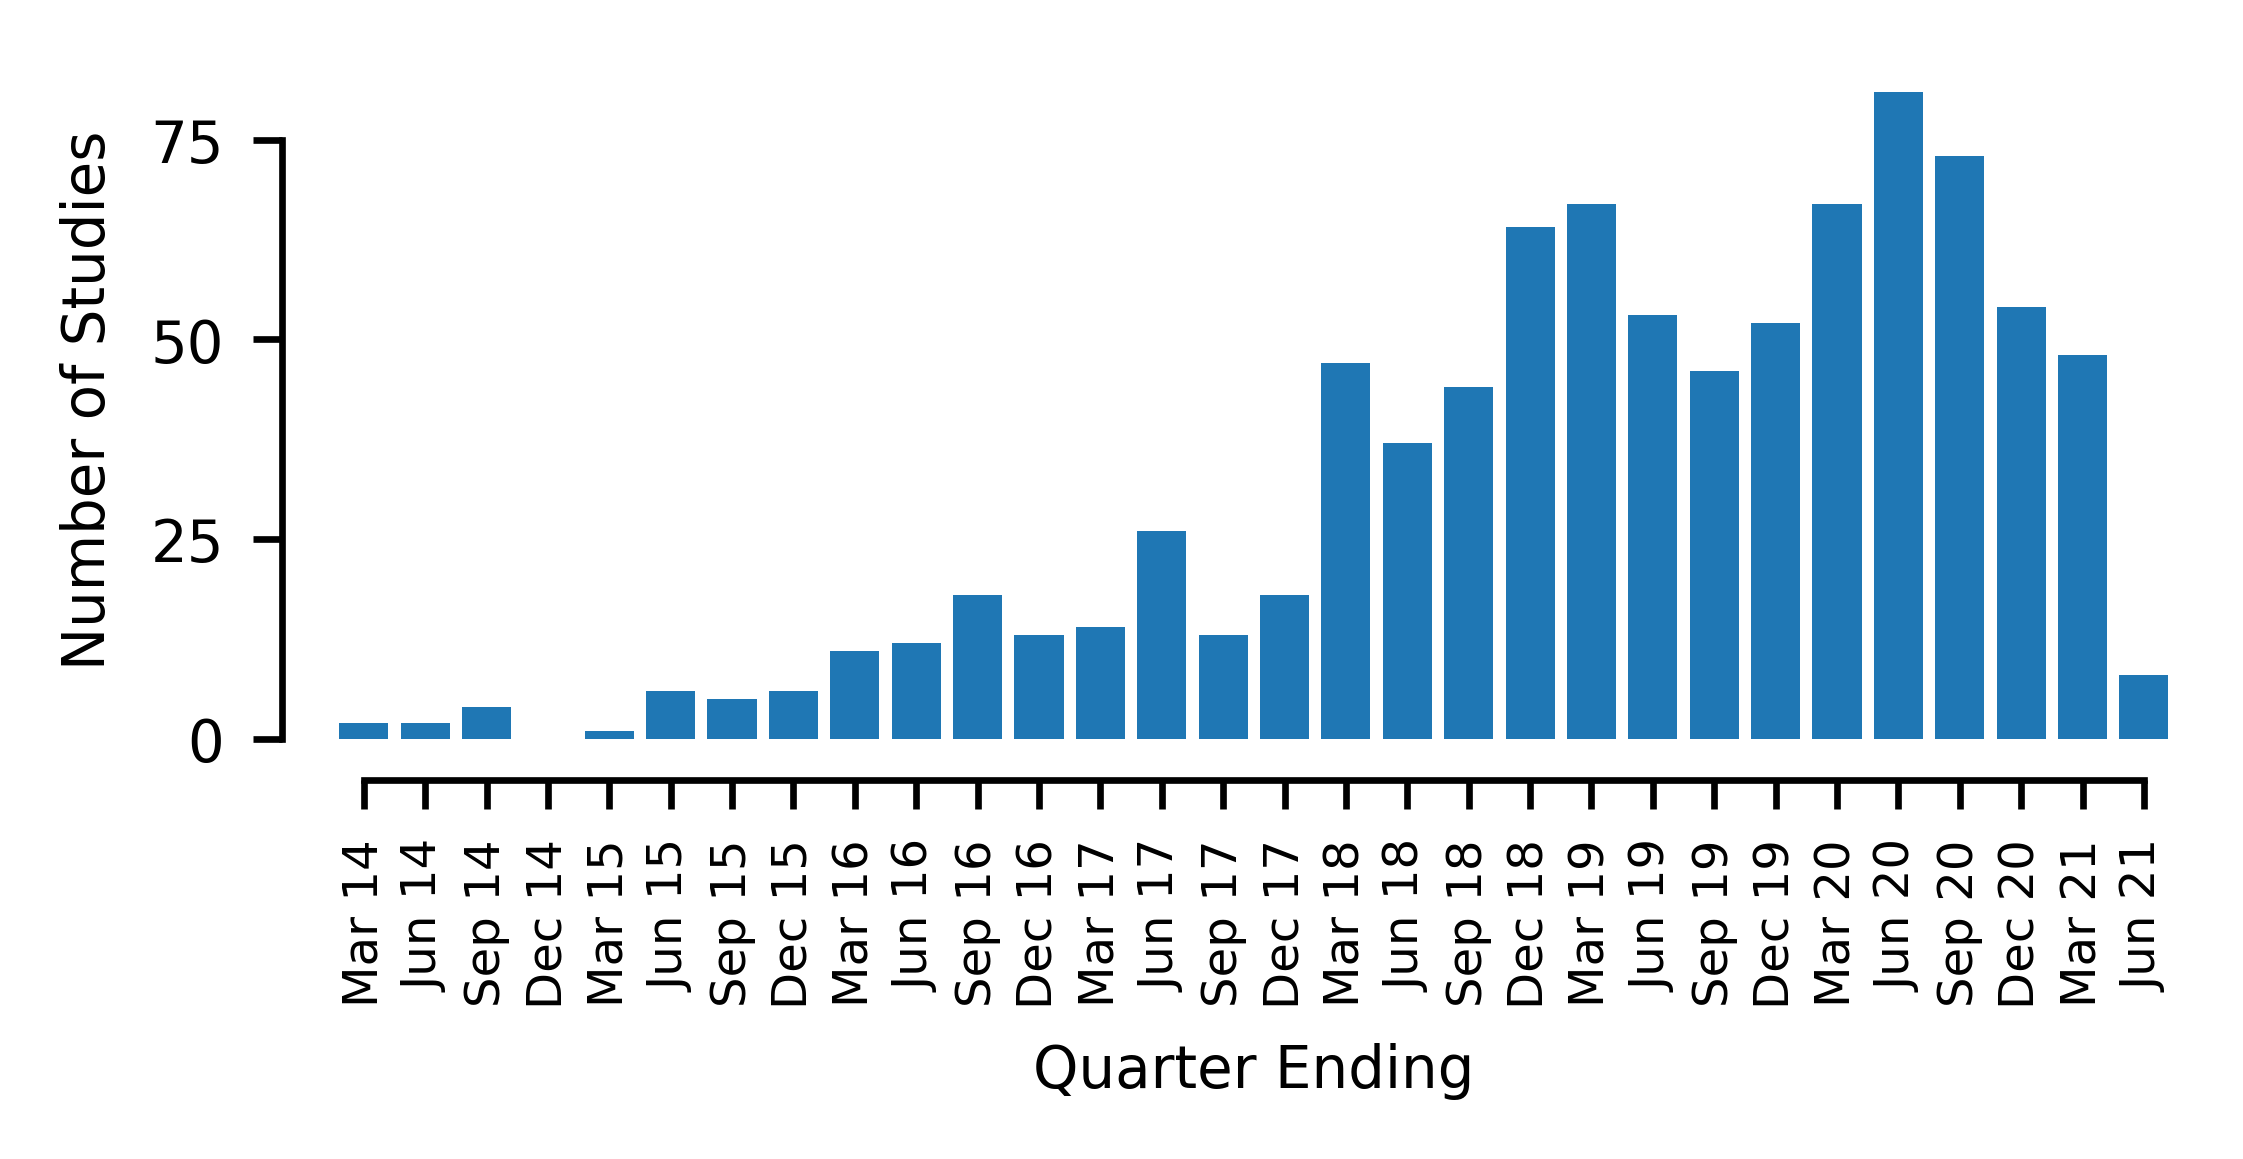

In [224]:
fig, ax = plt.subplots(1,1, figsize = (4,1.5), dpi = 600)

data.plot.bar(ax = ax, width = 0.8)
sns.despine(ax = ax, offset = 5, trim = True)
ax.xaxis.set_tick_params(labelsize = "xx-small", rotation = 90)
ax.yaxis.set_tick_params(labelsize = "x-small")
ax.set_ylabel("Number of Studies", fontsize = "x-small")
ax.set_xlabel("Quarter Ending", fontsize = "x-small")

In [3]:
import scanpy as sc
from ucdeconvolve.ucdeconvolve import _utils as ucdutils
from ucdeconvolve.ucdeconvolve._experimental import _exputils as ucdexputils

In [311]:
sheets = [pd.read_excel("/home/jupyter/manuscript/figure1/data/scdb.xlsx", sheet_name = x) for x in tqdm(list(range(9,25)))]

  0%|          | 0/16 [00:00<?, ?it/s]

In [353]:
celltypemarkers = {}
for sheet in tqdm(sheets):
    
    cols = sheet.columns.tolist()
    x = 'unlabeled_cell_type_assignment_final'
    y = 'markers'
    if (x not in cols) or (y not in cols): continue
    
    sheet = sheet[[x,y]].dropna()
    newmarkers = dict(zip(sheet[x], sheet[y]))
    for celltype, markers in newmarkers.items():
        
        celltype = celltype.strip().lower()
        
        markers = markers.split("/")
        markers = list(set([m.replace("+","").strip() for m in markers if m.endswith("+")]))
        markers = [m for m in markers if m in exp.columns.tolist()]
        
        if celltype not in celltypemarkers.keys():
            celltypemarkers[celltype] = set(markers)
        else:
            celltypemarkers[celltype].update(set(markers))
            
celltypemarkers = dict(zip(celltypemarkers.keys(), map(lambda x : list(x), celltypemarkers.values())))

  0%|          | 0/16 [00:00<?, ?it/s]

In [4]:
database_metadata = pd.read_csv("/home/jupyter/res_platforms_species_metadata_cells_all.csv").drop_duplicates()

database = sc.read_h5ad("/home/jupyter/data/database_features_allcells.h5ad")
database.X = np.clip(np.nan_to_num(database.X), 0, None)
database.var_names = ucdutils.metadata['target_genes']
database.obs = database.obs.merge(database_metadata, how = 'left', on = 'accession')
database.obs_names = database.obs_names.astype(str)
database.obs.platform = database.obs.platform.replace("10x Genomics;Seq-Well", "10X Genomics")

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [60]:
# Only subset protein coding genes
proteincodinggenes = pd.read_table("data/proteincodinggenes.txt")['symbol'].tolist()
proteincodinggenes = [x.upper() for x in proteincodinggenes]
proteincodinggenes = [x for x in proteincodinggenes if 'ORF' not in x]

exp = database.to_df().groupby(database.obs.celltype).mean()
exp = exp[np.intersect1d(exp.columns, proteincodinggenes)]

In [62]:
explfc = ucdexputils._logfoldchange(exp.values)
explfc = np.nan_to_num(explfc, nan = 0.0, posinf = 0.0, neginf = 0.0)
explfc = pd.DataFrame(explfc, columns = exp.columns, index = exp.index)

In [63]:
msorted = np.negative(explfc.values).argsort(axis = 1)

In [64]:
topmarkersidxs = msorted[:, :50]
topmarkers = np.zeros(topmarkersidxs.shape).astype(str)

In [65]:
for i, gene in tqdm(enumerate(exp.columns.tolist()), total = exp.shape[1]):
    topmarkers[np.where(topmarkersidxs == i)] = gene

  0%|          | 0/18331 [00:00<?, ?it/s]

In [66]:
topmarkers = pd.DataFrame(topmarkers, index = exp.index).iloc[1:].T

In [67]:
topmarkers.to_csv("data/celltypes_topmarkergenes.csv")

In [71]:
topmarkers.T.head(50)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
celltype,,,,,,,,,,,,,,,,,,,,,
3t3,PROKR1,EN1,OSR1,PRKG2,DLK1,IGLON5,PRRX2,LOX,PRRX1,GXYLT2,...,AZIN2,FGF10,CRLF1,IL1RL1,SHOX2,P3H3,PTGFR,PTGIS,ASB4,CAPN6
42mgba,LCE2A,SIGLEC15,GDF5,TEX29,CCL26,SPOCD1,MAGEA1,STC2,MMP3,MAGEA3,...,NPW,NEXN,PDCD1LG2,HES7,ZP1,JPH2,ALPK2,CBR3,PDLIM4,SPHK1
451lu,UCN2,TRIM51,TM4SF19,MMP20,BIRC7,MLANA,SLC45A2,HCG22,PMEL,TYR,...,DDTL,FAM156B,COL19A1,PIGY,ATP6V0D2,NPIPB3,CENPVL1,MAGED4B,GSTT2B,SERF1B
8305c,LCN1,MMP1,SIGLEC15,KRT33B,PAEP,APCDD1L,PAGE5,CSF3,SPANXN3,CLDN14,...,G0S2,CLEC11A,TMEM158,ADTRP,KCNMA1,FUT10,CACNG8,SPOCK1,INHBA,LARP6
a204,CRH,CLDN20,ITGA10,FGFBP2,NPTX1,HHLA2,HPD,COL11A1,HGF,SPAAR,...,BFSP1,PAPPA,CYP24A1,CUBN,FGFBP1,SIX1,PALM3,TBX2,MGP,DNER
a375,CT45A1,MAGEA2B,CTAG1A,CSAG3,MRGPRX4,MAGEA2,CT45A9,CTAG1B,SSX2B,CT45A10,...,IL24,GAGE12F,TRIM51,NUDT4B,OR51I1,FAM156B,MAGEA6,ANKRD30A,MIA,MAGEA3
a549,XAGE1B,H2AB3,GGTLC2,H4C12,XAGE1A,TM4SF20,ARSL,RAMACL,INSL4,CYP24A1,...,ATP5MJ,ZC3H11B,LGSN,AKR1C1,H2AZ1,NR0B1,H1-2,BOLA2B,H2AZ2,AOPEP
abc1,IGFL2,TCHHL1,VGLL1,XAGE3,GGTLC1,CST5,VCX2,ALPP,PLEKHG4B,NPPB,...,GPR87,MACC1,IGF2,BATF,KRT9,GJA5,LRTM2,S100A14,OPN3,PPP1R1C
acinar cell,CELA2B,AMY1A,AMY1B,CTRB2,CELA3A,AMY2A,CTRC,REG1B,CELA3B,CTRB1,...,AMY1C,HNRNPCL4,AQP8,SERPINA3,MT1HL1,AQP12B,SERPINA6,SERPINA4,IL22RA1,ERP27
